# 2022 EY Challenge

## JRC Global Surface Water Data

This notebook can be used to extract surface water data for any location. The dataset was generated from data collected by three separate satellites: Landsat 5, 7, and 8. The data provides statistics on the extent and change of surface water for different locations and times. You can learn more about the dataset [here](https://planetarycomputer.microsoft.com/dataset/jrc-gsw), or see a slightly more detailed description [here](https://developers.google.com/earth-engine/datasets/catalog/JRC_GSW1_3_GlobalSurfaceWater).


In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import rasterio.features
import rasterio as rio
import rioxarray
# import xrspatial.multispectral as ms

# Import Planetary Computer tools
import stackstac
import pystac
import pystac_client
import planetary_computer

# Plotting tools
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Table visualisation tools
import pandas as pd
from IPython.display import display, HTML

### Discover and load the data for analysis

First, we define our area of interest using latitude and longitude coordinates. Our test region is near Richmond, NSW, Australia. The first line defines the lower-left corner of the bounding box and the second line defines the upper-right corner of the bounding box. GeoJSON format uses a specific order: (longitude, latitude), so be careful when entering the coordinates.

In [2]:
# Richmond
min_lon, min_lat = (150.62, -33.69)  # Lower-left corner
max_lon, max_lat = (150.83, -33.48)  # Upper-right corner
bbox = (min_lon, min_lat, max_lon, max_lat)

# # Bangladesh
# min_lon, min_lat = (90.81, 24.08)  # Lower-left corner
# max_lon, max_lat = (91.20, 24.80)  # Upper-right corner
# bbox = (min_lon, min_lat, max_lon, max_lat)

# # Hornsby
# min_lon, min_lat = (151.04, -33.72)  # Lower-left corner
# max_lon, max_lat = (151.11, -33.67)  # Upper-right corner
# bbox = (min_lon, min_lat, max_lon, max_lat)

Using the `pystac_client` we can search the Planetary Computer's STAC endpoint for items matching our query parameters.
<br>The surface water data is an amalgamation of many thousands of timeseries images, so there is no need to query a timeframe or filter for cloud cover. (The change in time is captured in the `change` band, which quantifies the change in surface water between epoch 1984-1999 and epoch 2000-2019.)
<br>The result is one, clean scene for our region of interest.

In [3]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bbox,
    collections=["jrc-gsw"]
)

items = list(search.get_items())
print('This is the number of scenes that touch our region:',len(items))



This is the number of scenes that touch our region: 1


In [4]:
# Since theres only one scene
item = items[0]

Below extracts the bands that are available, as well as their descriptions. We save the asset keys in `cog_assets` so that we can reference them later.


In [5]:
# Extract asset info and store it in a table (purely for display purposes)
assets = pd.DataFrame()
for asset_key, asset in item.assets.items():
    if asset.media_type == pystac.MediaType.COG:
        asset_info = pd.DataFrame(asset.to_dict())
        asset_info['STAC Key'] = asset_key
        assets = assets.append(asset_info)
        
assets = assets.reset_index(drop=True)
assets = assets[['STAC Key', 'title', 'description']]
          
# Save asset keys to list
cog_assets = list(assets['STAC Key'])

# Truncate description for display
assets.description = assets.description.str.wrap(100)
display(HTML(assets.to_html().replace("\\n","<br>")))

,STAC Key,title,description
0,change,Water Occurrence Change,"Provides information on where surface water occurrence increased, decreased or remained the samebetween 1984-1999 and 2000-2020. Both the direction of change and its intensity are documented."
1,extent,Maximum Water Extent,Provides information on all the locations ever detected as water over a 37-year period. It is theunion of all of the other datasets
2,occurrence,Water Occurrence,Shows where surface water occurred between 1984 and 2020 and provides information concerning overallwater dynamics. This product captures both the intra and inter-annual variability and changes.
3,recurrence,Water Recurrence,Provides information concerning the inter-annual behavior of water surfaces and captures thefrequency with which water returns from year to year.
4,seasonality,Water Seasonality,Provides information concerning the intra-annual behaviour of water surfaces for a single year(2020) and shows permanent and seasonal water and the number of months waterwas present.
5,transitions,Water Transitions,"Provides information on the change in seasonality between the first and last years and captureschanges between the three classes of not water, seasonal water, and permanent water."


Each asset has an associated colourmap that is worth extracting to make our plots more aesthetically pleasing. The following extracts the colourmaps and stores them in matplotlib cmap format.

In [6]:
cmaps = {}
for asset_key in cog_assets:
    asset_url = item.assets[asset_key].href
    with rasterio.open(asset_url) as src:
        colormap_def = src.colormap(1)  # get metadata colormap for band 1
        colormap = [
            np.array(colormap_def[i]) / 256 for i in range(256)
        ]  # transform to matplotlib color format
    cmaps[asset_key] = ListedColormap(colormap)

Next, we'll load the data into an [xarray](https://xarray.pydata.org/en/stable/) DataArray using [stackstac](https://stackstac.readthedocs.io/) and then "clip" the data to only the pixels within our region (bounding box). We will keep all six bands. There are also several other <b>important settings for the data</b>: We have changed the projection to epsg=4326 which is standard latitude-longitude in degrees. We have specified the spatial resolution of each pixel to be 10-meters. This resolution can be easily changed below (e.g. 100 meters) to reduce the data volume of the final GeoTIFF output. This change may be neccesary when considering larger analysis regions. Also, we have selected a resampling method of "average" that will find the mean value of each band to create new pixels. This is only needed when the resolution is changed from 10-meters to larger values (e.g. 100 meters). 

In [7]:
# Define the pixel resolution for the final product
# Define the scale according to our selected crs, so we will use degrees
resolution = 10  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for crs=4326 

In [8]:
data = (
    stackstac.stack(
        item,
        epsg=4326, # Use common Lat-Lon coordinates
        resolution=scale, # Use degrees for crs=4326
        bounds_latlon = bbox,
        # resampling=rasterio.enums.Resampling.average, # Average resampling method (only required when resolution >10)
        # assets=["extent"], 
        chunksize=4096,  
    )
    # .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
    # .assign_coords(band=lambda x: x.title)  # use common names
)

Since the data matching our query isn't too large we can persist it in distributed memory. Once in memory, subsequent operations will be much faster.

In [9]:
data = data.persist()

In [10]:
# Remove the time dimension, since there is only one item
data = data[0]

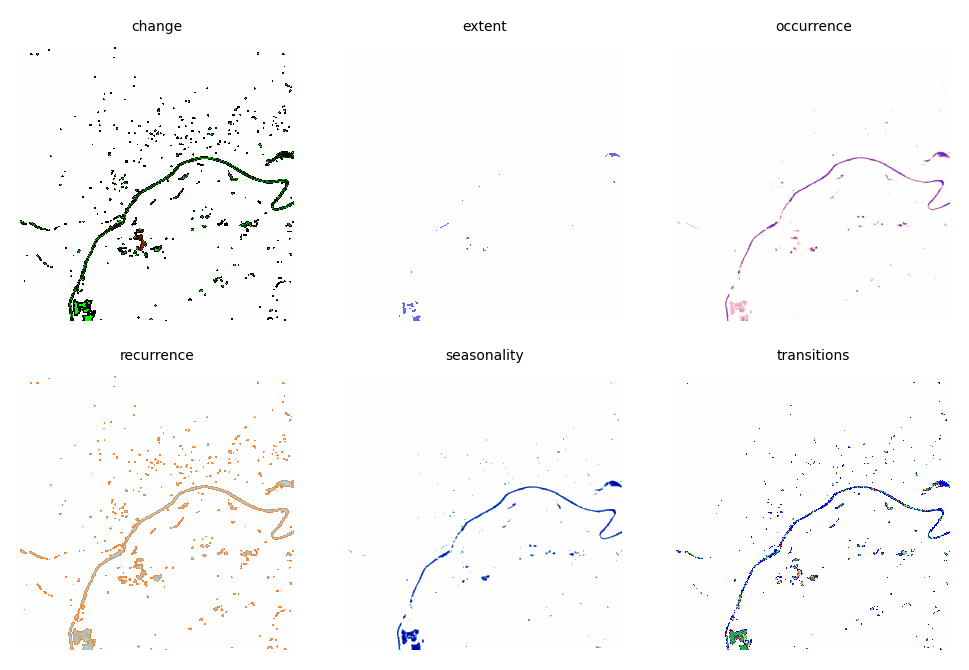

In [11]:
from matplotlib.colors import Normalize
import cv2

dpi = 200
fig = plt.figure(frameon=False, dpi=dpi)

for i, asset_key in enumerate(cog_assets):
    ax1 = fig.add_subplot(int(f"23{i+1}"))
    ax1.set_title(asset_key, fontdict={"fontsize": 5})
    ax1.set_axis_off()
    img = np.array(data.sel(band = asset_key))
    plt.imshow(
        # cv2.dilate(img, np.ones((50,50)), iterations=1),
        img,
        norm=Normalize(0, 255),  
        cmap=cmaps[asset_key]
    )

### Save the output data to a NetCDF4 file

In [12]:
# Only keep x, y, and band coordinates (others cause trouble when saving)
for key in list(data.coords.keys()):
    if key not in ['x', 'y', 'band']:
        del data.coords[key]

# Remove all attributes (also cause trouble)
data.attrs = {}

# Save to file
filename = "jrc_mosaic_sample.nc"
data.to_netcdf(filename)

In [13]:
# Read from file
xr.open_dataset(filename).load().to_array()

<xarray.DataArray (variable: 1, band: 6, y: 2339, x: 2339)>
array([[[[253., 253., 253., ..., 253., 253., 253.],
         [253., 253., 253., ..., 253., 253., 253.],
         [253., 253., 253., ..., 253., 253., 253.],
         ...,
         [253., 253., 253., ..., 253., 253., 253.],
         [253., 253., 253., ..., 253., 253., 253.],
         [253., 253., 253., ..., 253., 253., 253.]],

        [[  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         ...,
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.]],

        [[  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         ...,
...
         ...,
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.]],

        [[  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         ...,
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.]],

        [[  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         ...,
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.]]]])
Coordinates:
  * x         (x) float64 150.6 150.6 150.6 150.6 ... 150.8 150.8 150.8 150.8
  * y         (y) float64 -33.48 -33.48 -33.48 -33.48 ... -33.69 -33.69 -33.69
  * band      (band) object 'change' 'extent' ... 'seasonality' 'transitions'
  * variable  (variable) <U42 'stackstac-fb70907e3df2e962be90baaa972761dc'

### Save data to a GeoTIFF file (WIP)

In [ ]:
filename = "jrc_mosaic_sample.tiff"

In [ ]:
# This will report the pixel dimensions of our mosaic file. Recall that pixel resolution will impact the dimensions.
data.sel(band="occurrence").shape

In [ ]:
height = data.sel(band="occurrence").shape[0]
width = data.sel(band="occurrence").shape[1]

In [32]:
with rasterio.open(filename,'w',driver='GTiff',width=width,height=height,count=len(cog_assets),compress='lzw',dtype='float64', crs="EPSG:4326") as dst:
    dst.write(data)
    
    for i, band in enumerate(cog_assets):
        img = data.sel(band=band)
        dst.write_band(i+1, img)
        dst.set_band_description(i+1, band)
        
    dst.close()

In [18]:
# Show the location and size of the new output file
!ls *.tiff -lah

-rw-rw-r-- 1 billy billy 570K Dec 16 06:11 S2_mosaic_sample.tiff
-rw-rw-r-- 1 billy billy 8.7M Jan 11 05:20 jrc_mosaic_sample.tiff


data### How will the participants use this data?
The GeoTIFF file will contain the Lat-Lon coordinates of each pixel and will also contain the mean band values (Red, Green, Blue, NIR) for each pixel as separate data layers. These band values can be easily used to calculate indices such as NDVI (vegetation) or NDWI (water). Since the FrogID data is also Lat-Lon position, it is possible to find the closest Sentinel-2 mosaic pixel using code similar to what is demonstrated below. Once this pixel is found, then the corresponding spectral data (values) can be used for modeling species distribution. 